# Obenter matriz de adyacencia entre grupos

Ya que los puntos del grafo original pertenecen a 35 grupos, es necesario realizar la matriz de adyacencia que conecte únicamente los centros. Esto servirá para realizar una consulta a Google Api sobre el tiempo que se tarda viajar de un grupo al siguiente.

In [4]:
import osmnx as ox
import networkx as nx 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Se carga el modelo de grupos y los colores.

In [2]:
import pickle
with open('Cluster_map.pickle', 'rb') as handle:
    graph = pickle.load(handle)

In [7]:
colors_data = pd.read_csv('colores_mapa.csv')

In [8]:
colors_num = list(colors_data['colors'])

In [10]:
colors_num[:10]

[0, 0, 29, 21, 21, 13, 14, 12, 12, 4]

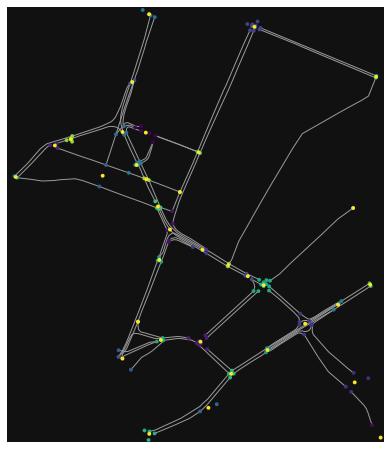

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [13]:
ox.plot_graph(graph, 
             node_color=colors_num)

In [23]:
data = pd.read_csv('nodos_dataset.csv')

Se extraen las conexiones del grafo para revisar las conexioines entre centros.

In [14]:
edges = list(graph.edges())

In [15]:
edges[:10]

[(264268564, 264268569),
 (264268569, 267939607),
 (264268569, 264268564),
 (264270346, 267939758),
 (264270354, 3726280025),
 (267036924, 267960698),
 (267036924, 3726294618),
 (267036926, 4207542605),
 (267036926, 267036924),
 (267036927, 267939876)]

In [16]:
len(edges)

90

In [18]:
adj_matrix = np.zeros((35,35))

In [19]:
adj_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Oneway significa que va en una sola dirección.

In [20]:
graph.edges[(264268564, 264268569, 0)]

{'osmid': [356064688, 107938398],
 'oneway': False,
 'name': 'San Gregorio',
 'highway': 'tertiary',
 'length': 205.81,
 'geometry': <shapely.geometry.linestring.LineString at 0x201e27293d0>}

In [24]:
for nodo1,nodo2 in edges:
    cluster1 = int(data['cluster'][np.where(data['nodos']==nodo1)[0]])
    cluster2 = int(data['cluster'][np.where(data['nodos']==nodo2)[0]])
    adj_matrix[cluster1][cluster2] = 1    
    #si es doble vía
    if (not graph.edges[(nodo1,nodo2,0)]['oneway']):
        adj_matrix[cluster2][cluster1] = 1 
        

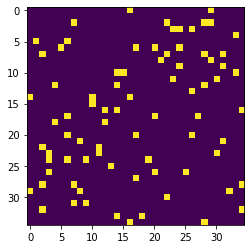

In [26]:
plt.imshow(adj_matrix)

In [27]:
np.where(adj_matrix[0]==1)

(array([16, 29], dtype=int64),)

In [29]:
np.where(adj_matrix[16]==1)

(array([12, 14, 34], dtype=int64),)

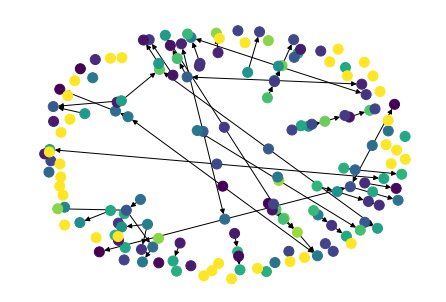

In [11]:
positions = {}
g_nodes = list(graph.nodes())
for node_name in g_nodes:
    positions[node_name] = (graph.nodes[node_name]['x'],graph.nodes[node_name]['y'])
nx.draw(graph,node_size=100,node_color=colors_num_2)

In [12]:
G = nx.DiGraph(adj_matrix)

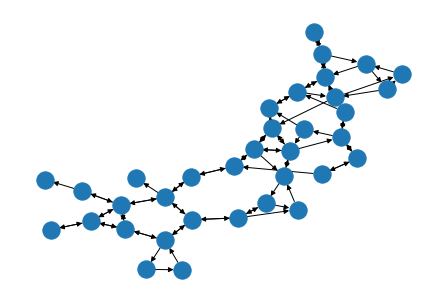

In [18]:
pos = nx.circular_layout(G)
nx.draw_kamada_kawai(G)

In [7]:
centros

[(-78.50040125, -0.20248826666666667),
 (-78.49079993333334, -0.21495733333333333),
 (-78.49941296, -0.20644891999999998),
 (-78.4981667125, -0.21103442500000003),
 (-78.50411983333333, -0.20301313333333335),
 (-78.491860325, -0.2126993),
 (-78.49388817142858, -0.21029951428571433),
 (-78.498081775, -0.20728062500000002),
 (-78.49596283, -0.19816061999999998),
 (-78.49622876666668, -0.2083583),
 (-78.50095725, -0.20041799999999999),
 (-78.5013562, -0.211726575),
 (-78.5021648, -0.2042497),
 (-78.4978411, -0.21373910000000002),
 (-78.5013519, -0.20246205),
 (-78.50026352500001, -0.197645025),
 (-78.5007766, -0.20381238333333332),
 (-78.49254119999999, -0.20952433333333334),
 (-78.50571395, -0.20430165),
 (-78.4919239, -0.20557),
 (-78.49542793333333, -0.21137536666666668),
 (-78.49098605, -0.20020670000000002),
 (-78.49984930000001, -0.20768993333333333),
 (-78.49978503333334, -0.21096573333333335),
 (-78.49558266363637, -0.20872455454545458),
 (-78.500259975, -0.214803425),
 (-78.49691

In [10]:
data_centers = pd.DataFrame(adj_matrix)

In [13]:
data_centers['cluster_point'] = centros

In [14]:
data_centers

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,cluster_point
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(-78.50040125, -0.20248826666666667)"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.49079993333334, -0.21495733333333333)"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"(-78.49941296, -0.20644891999999998)"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.4981667125, -0.21103442500000003)"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(-78.50411983333333, -0.20301313333333335)"
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.491860325, -0.2126993)"
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.49388817142858, -0.21029951428571433)"
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"(-78.498081775, -0.20728062500000002)"
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(-78.49596283, -0.19816061999999998)"
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(-78.49622876666668, -0.2083583)"


In [15]:
data_centers.to_csv(r'centros_googleApi')